# Experimenting with Analytics Zoo AutoML experimental features

## Overview
Analytics Zoo is a unified data analytics and AI platform open sourced by Intel. It is basically a complete environment (including Jupyter Notebook server) for ML. It is put together by bits and pieces already out there and for the AutoML experimental setup they have also connected it to a scalable backend using Ray and Apache Spark. The following image gives an overview of the Analytics Zoo setup for AutoML using a scalable backend based on Tensorflow, Keras, Ray and Apache Spark. The AutoML part is a layer on top of the backend and the individual use cases are in a thin App layer, e.g. TimeSequencePredictor, which is an "App" for multivariant input/single variant output time series prediction on top of the underlaying architecture.

![Analytics Zoo on Ray](AnalyticZooAutoML-overview.png)

## Prepare a Conda environment 
For the testing I did set up an Ubuntu 18.04 virtual machine with 32 cores and 100GB RAM. When the VM was ready I did install Anaconda first:
```
# Download Anaconda
curl -O https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
#Install Anaconda
bash Anaconda3-2019.10-Linux-x86_64.sh
```
I then created an Anaconda environment and populated it with the needed packages:

```
# Create a Conda environment and activate it
conda create -n zoo python=3.6
conda activate zoo

# Installed all necessary packages with Conda
conda install tensorflow
conda install -c anaconda scikit-learn
conda install -c conda-forge featuretools
conda install pandas
conda install matplotlib
conda install requests
conda install aiohttp psutil setproctitle grpcio
conda install -c conda-forge tabulate
conda install -c conda-forge setproctitle
conda install jupyter
conda install -c anaconda openjdk=8.0.152

# Use pip to install the rest of the packages (that are not supported by conda)
pip install pyspark==2.4.3
pip install ray==0.8.0
pip install tune
```


## Get and compile the AnalyticsZoo AutoML package
To get the experimental AnalyticsZoo AutoML package we need to download and compile the source code for the AutoML branch. In order to do that we also need Maven:
```
sudo apt install maven
```

```
# Clone repo autoML branch
git clone --single-branch --branch automl https://github.com/intel-analytics/analytics-zoo.git

# Compile the AutoML branch (for linux) with Spark support (all the -D options)
bash analytics-zoo/pyzoo/dev/build.sh linux default -Dspark.version=2.4.3 -Dbigdl.artifactId=bigdl-SPARK_2.4 -P spark_2.4+

```
Install the newly compiled Analytics Zoo package (se above)
```
pip install analytics-zoo/pyzoo/dist/analytics_zoo-0.6.0.dev0-py2.py3-none-manylinux1_x86_64.whl
```

## Run the example

In [1]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [5]:
# load nyc taxi data
try:
    dataset_path = "nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/dist/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

In [6]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, val_split_ratio=0.1, test_split_ratio=0.1)

Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.9.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [7]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [8]:
train_df.head(5)

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [9]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


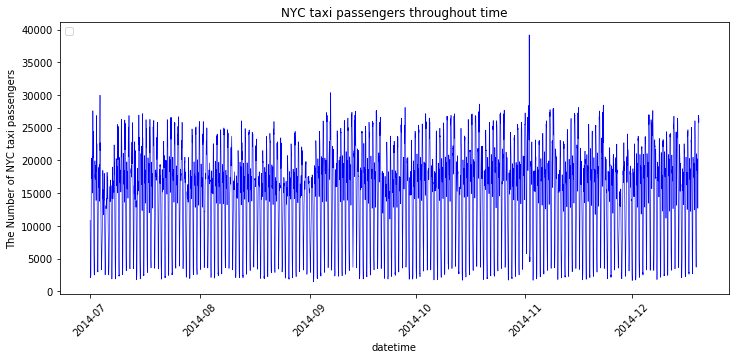

In [10]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

In [11]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [12]:
from zoo.ray.util.raycontext import RayContext
from zoo import init_spark_on_local

sc = init_spark_on_local(cores=4)
ray_ctx = RayContext(sc=sc)

Current pyspark location is : /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched


In [13]:
ray_ctx.init()

Start to launch ray on cluster
Start to launch ray on local


In [14]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=(2, 4)))
print("Training completed.")

Trial name,status,loc,batch_size,selected_features,dropout_1,dropout,lr,model,past_seq_len,lstm_2_units,lstm_1_units,dropout_2,latent_dim,iter,total time (s)
train_func_efce429c,TERMINATED,,1024,['HOUR(datetime)' 'IS_AWAKE(datetime)' 'IS_WEEKEND(datetime)' 'MONTH(datetime)'],0.407214,0.365972,0.00603901,LSTM,2,8,32,0.459154,64,6,12.6984


2020-02-27 13:56:36,686	INFO tune.py:334 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


TypeError: 'ExperimentAnalysis' object is not iterable

# There still seems to be some problems....
The list of installed packages in the Conda environment can be found in the conda-list.txt file in the github repo (result of conda list).

